In [1]:
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import ipywidgets as widgets
import pandas as pd
import io

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import InputLayer, Flatten, Dense

In [2]:
!mkdir ~/.kaggle


In [3]:
!cp kaggle.json ~/.kaggle/


In [4]:
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d andri088/belens-dataset


Dataset URL: https://www.kaggle.com/datasets/andri088/belens-dataset
License(s): unknown
 96% 284M/295M [00:01<00:00, 224MB/s]
100% 295M/295M [00:01<00:00, 187MB/s]


In [6]:
!unzip belens-dataset.zip -d /content/belens-dataset

Archive:  belens-dataset.zip
  inflating: /content/belens-dataset/Minuman Dataset/ABC Kopi Susu/Abc Kopi Susu - 1.jpeg  
  inflating: /content/belens-dataset/Minuman Dataset/ABC Kopi Susu/Abc Kopi Susu - 110.jpg  
  inflating: /content/belens-dataset/Minuman Dataset/ABC Kopi Susu/Abc Kopi Susu - 111.jpg  
  inflating: /content/belens-dataset/Minuman Dataset/ABC Kopi Susu/Abc Kopi Susu - 112.jpeg  
  inflating: /content/belens-dataset/Minuman Dataset/ABC Kopi Susu/Abc Kopi Susu - 113.jpeg  
  inflating: /content/belens-dataset/Minuman Dataset/ABC Kopi Susu/Abc Kopi Susu - 114.jpeg  
  inflating: /content/belens-dataset/Minuman Dataset/ABC Kopi Susu/Abc Kopi Susu - 115.jpg  
  inflating: /content/belens-dataset/Minuman Dataset/ABC Kopi Susu/Abc Kopi Susu - 116.jpg  
  inflating: /content/belens-dataset/Minuman Dataset/ABC Kopi Susu/Abc Kopi Susu - 117.jpeg  
  inflating: /content/belens-dataset/Minuman Dataset/ABC Kopi Susu/Abc Kopi Susu - 118.jpg  
  inflating: /content/belens-dataset/M

In [7]:
# Path direktori hasil ekstraksi
data_dir = '/content/belens-dataset/Minuman Dataset'

# Tampilkan daftar folder di direktori dataset
print("Files in directory:", os.listdir(data_dir))

# Hitung jumlah kategori (subfolder)
print("Number of categories (folders):", len(os.listdir(data_dir)))

#jumlah produk diambil dari total folder
num_classes = len(os.listdir(data_dir))

#Penyesuaian ukuran gambar
image_size = 120

Files in directory: ['Sprite 390ml', 'Larutan Penyegar Rasa Jambu', 'Ichitan Thai Green Tea', 'Fruit Tea Freeze 350ml', 'Yakult', 'Cimory Yogurt Strawberry', 'Golda Cappucino', 'BearBrand', 'Nutriboost Orange Flavour 250ml', 'Pepsi Blue 330 ml', 'Ultra Milk Coklat Ultrajaya 200ml', 'Floridina 350ml', 'Teh kotak 200 ml', 'Fanta Strawberry 390ml', 'Tehbotol sosro 250ml', 'Tebs Sparkling 330ml', 'Teh Pucuk Harum', 'Cimory Cashew 250ml', 'Mizone 500ml', 'You C 1000 Orange', 'Garantea', 'Ultramilk Fullcream 250ml', 'Hydro Coco Original 250 ml', 'Cimory Bebas Laktosa 250ml', 'NU Green Tea Yogurt', 'Benecol Lychee 100ml', 'Pocari Sweat 500 ml', 'Oatside Cokelat', 'ABC Kopi Susu', 'Cola-Cola 390ml']
Number of categories (folders): 30


In [8]:
#Fungsi untuk augmentasi model
def create_augmentation_model():
    """Creates a model (layers stacked on top of each other) for augmenting images.

    Returns:
        tf.keras.Model: The model made up of the layers that will be used to augment the images.
    """
    augmentation_model = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomTranslation(0.2, 0.2),
    ])
    return augmentation_model

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Sequential

#Fungsi untuk membuat model
def create_classification_model(image_size, num_classes):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    return model

In [10]:
def preprocess_image(file_path, image_size):
    """
    Fungsi untuk memproses gambar: memuat gambar, mengubah ukurannya, dan menormalkan.
    Args:
        file_path (str): Path file gambar
    Returns:
        tf.Tensor: Gambar yang sudah diproses
    """
    # Membaca gambar
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Mengkodekan gambar dalam format RGB

    # Mengubah ukuran gambar sesuai ukuran gambar yang ditentukan di image_size
    image = tf.image.resize(image, [image_size, image_size])

    # Normalisasi gambar (opsional, bisa disesuaikan)
    image = image / 255.0  # Mengubah nilai pixel menjadi antara 0 dan 1

    return image


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators(data_dir, image_size):
    """Creates ImageDataGenerators for training and validation with augmentation for a simple CNN."""
    train_datagen = ImageDataGenerator(
        rescale=1./255,  # Normalisasi sederhana
        rotation_range=20,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        validation_split=0.2  # Membagi data menjadi pelatihan dan validasi dengan perbandingan 1/5
    )

    # Generator untuk set pelatihan
    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        subset='training'  # Menggunakan subset training
    )

    # Generator untuk set validasi (tanpa augmentasi tambahan)
    val_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        subset='validation'  # Menggunakan subset validation
    )

    return train_generator, val_generator

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model(model, train_generator, val_generator, epochs, patience, save_path): # Changed the file extension to .keras

    # Compile model
    Optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callback untuk menghentikan pelatihan lebih awal jika tidak ada perbaikan pada set validasi
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Callback untuk menyimpan model terbaik selama pelatihan
    model_checkpoint = ModelCheckpoint(save_path, monitor='val_loss', save_best_only=True)

    # Melatih model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping, model_checkpoint]
    )

    return history

In [13]:
# Membuat model augmentasi
augmentation_model = create_augmentation_model()

# Membuat model klasifikasi dengan transfer learning
classification_model = create_classification_model(image_size, num_classes)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


True


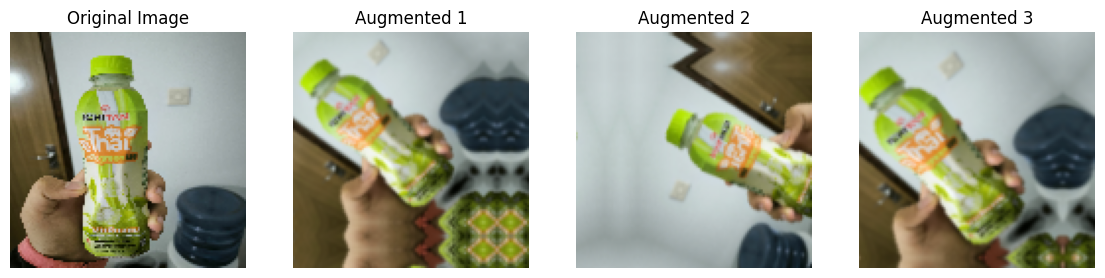

In [14]:
# Path gambar
path = "/content/belens-dataset/Minuman Dataset/Ichitan Thai Green Tea/ICHI1 (1).jpg"
print(os.path.exists(path))

dataset = tf.data.Dataset.list_files(path)
dataset = dataset.map(lambda x: preprocess_image(x, image_size))  # Fungsi untuk memproses gambar
dataset = dataset.batch(32)  # Mengambil batch berisi 32 gambar

# Ambil batch pertama
example_batch_images = next(iter(dataset))
sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

# Terapkan augmentasi acak 3 kali
images = [sample_image]

for _ in range(3):
    # Tambahkan dimensi batch (misalnya, batch size 1)
    image_with_batch = tf.expand_dims(sample_image, axis=0)

    # Augmentasi gambar
    image_aug = augmentation_model(image_with_batch)
    image_aug = tf.image.resize(image_aug, [image_size, image_size])  # Resize augmented images
    image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
    images.append(image_aug)


# Menampilkan gambar
fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image)
    ax.set_title(title)
    ax.axis('off')

plt.show()

In [15]:
#melakukan training model
train_generator, val_generator = create_data_generators(data_dir, image_size)
history = train_model(classification_model, train_generator, val_generator, epochs=100, patience=20, save_path='best_model.keras')

Found 1209 images belonging to 30 classes.
Found 297 images belonging to 30 classes.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0320 - loss: 3.4133

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.0319 - loss: 3.4132 - val_accuracy: 0.0808 - val_loss: 3.3970
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.0479 - loss: 3.3856 - val_accuracy: 0.1212 - val_loss: 3.2502
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.0871 - loss: 3.2994 - val_accuracy: 0.0943 - val_loss: 3.1749
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.1058 - loss: 3.2114 - val_accuracy: 0.1650 - val_loss: 3.0657
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.1131 - loss: 3.1419 - val_accuracy: 0.1178 - val_loss: 3.1560
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.0885 - loss: 3.1373 - val_accuracy: 0.1515 - val_loss: 2.9084
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.1057 - loss: 3.0261 - val_accuracy: 0.1886 - val_loss: 2.6901
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.1462 - loss: 2.8095 - val_accuracy: 0.2222 - val_loss: 2.5

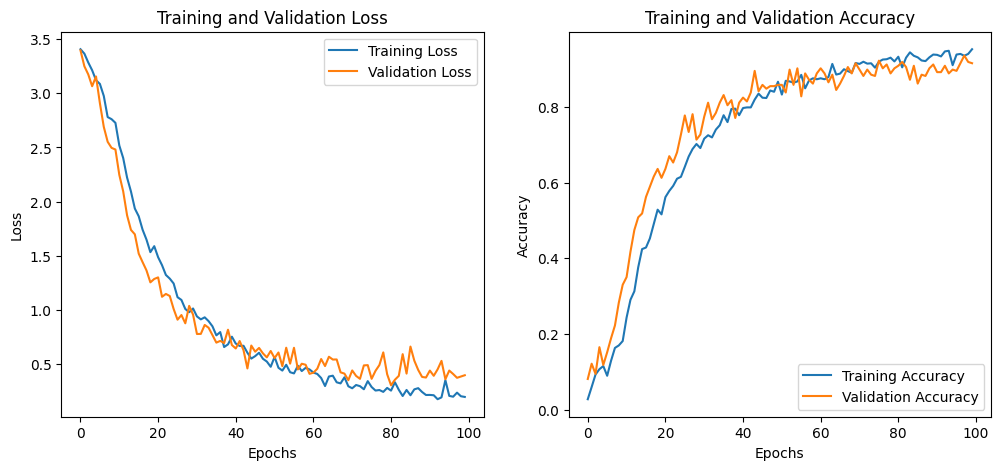

In [16]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


In [18]:
from io import BytesIO
from IPython.display import display, HTML


# Pastikan model Anda sudah diload sebelumnya
model = classification_model  # Menggunakan model klasifikasi yang dibuat sebelumnya

# Widget untuk meng-upload gambar
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)

out = widgets.Output()
display(out)

# Load file CSV
df_nutrition = pd.read_csv('/content/MINUMAN NUTRITION.csv')

def preprocess_and_augment(file):
    """
    Fungsi untuk memuat, memproses, dan augmentasi gambar.
    Args:
        file (str): Nama file gambar
    Returns:
        np.array: Gambar yang telah diproses dan diaugmentasi
    """
    # Memuat dan mengubah ukuran gambar
    img = tf.keras.utils.load_img(file, target_size=(image_size, image_size))
    img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalisasi nilai antara 0 dan 1

    # Augmentasi gambar menggunakan augmentation_model
    img_array = tf.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch
    augmented_img = augmentation_model(img_array)
    return tf.squeeze(augmented_img).numpy()  # Menghapus dimensi batch yang tidak diperlukan

def file_predict(filename, file, out):
    """ Fungsi untuk membuat prediksi, mencetak hasil output, dan menampilkan gambar yang di-upload """
    # Memuat dan mengubah ukuran gambar asli tanpa augmentasi untuk ditampilkan
    original_img = tf.keras.utils.load_img(file, target_size=(image_size, image_size))
    original_img_array = tf.keras.utils.img_to_array(original_img) / 255.0  # Normalisasi nilai antara 0 dan 1

    # Proses dan augmentasi gambar untuk prediksi
    img_array = preprocess_and_augment(file)
    img_array = np.expand_dims(img_array, axis=0)  # Membuat dimensi batch untuk prediksi

    # Prediksi gambar
    prediction = model.predict(img_array, verbose=0)

    # Menentukan kategori berdasarkan output model
    pred_class = np.argmax(prediction, axis=1)[0]
    label_map = {
        0: 'ABC Kopi Susu',
        1: 'BearBrand',
        2: 'Benecol Lychee 100ml',
        3: 'Cimory Susu Coklat Cashew',
        4: 'Cimory Yogurt Strawberry',
        5: 'Cimory Bebas Laktosa 250ml',
        6: 'Cola-Cola 390ml',
        7: 'Fanta Strawberry 390ml',
        8: 'Floridina 350ml',
        9: 'Fruit Tea Freeze 350ml',
        10: 'Garantea',
        11: 'Golda Cappucino',
        12: 'Hydro Coco Original 250ml',
        13: 'Ichitan Thai Green Tea',
        14: 'Larutan Penyegar rasa Jambu',
        15: 'Mizone 500ml',
        16: 'NU Green Tea Yogurt',
        17: 'Nutri Boost Orange Flavour 250ml',
        18: 'Oatside Cokelat',
        19: 'Pepsi Blue 330ml',
        20: 'Pocari Sweat 500 ml',
        21: 'Sprite 390ml',
        22: 'Tebs Sparkling 330ml',
        23: 'Teh Kotak 200ml',
        24: 'Teh Pucuk Harum',
        25: 'Tehbotol Sosro 250ml',
        26: 'Ultra Milk Coklat Ultrajaya 200ml',
        27: 'Ultramilk Fullcream 250ml',
        28: 'Yakult',
        29: 'You C 1000 Orange'

    }


    category = label_map[pred_class]

    with out:
        # Menampilkan gambar asli yang di-upload (tanpa augmentasi)
        plt.imshow(tf.keras.utils.array_to_img(original_img_array))
        plt.axis('off')
        plt.title(f"Uploaded Image (Original): {filename}")
        plt.show()

        # Menampilkan hasil prediksi kategori
        print(f"<b>Gambar '{filename}' termasuk dalam kategori:</b> <u>{category}</u>", end="\n\n")

        # Mencari data nutrisi dari file CSV berdasarkan kategori
        nutrition_info = df_nutrition[df_nutrition['nama_produk'] == category]

        if not nutrition_info.empty:
            # Menampilkan data nutrisi sebagai tabel HTML
            print("Informasi Gizi:")
            display(HTML(nutrition_info.to_html(index=False)))
        else:
            print("<i>Data nutrisi tidak ditemukan untuk kategori ini.</i>", end="\n\n")

def on_upload_change(change):
    """ Fungsi untuk mengambil file dari widget dan menjalankan prediksi """
    # Mendapatkan file yang diupload
    for name, data in change.new.items():
        file_jpgdata = BytesIO(data['content'])  # Access content from the data dictionary
        file_predict(name, file_jpgdata, out)

# Mengamati perubahan pada widget upload
uploader.observe(on_upload_change, names='value')

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

Output()